In [53]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle


In [54]:
df = pd.read_csv('modified_cropyield.csv')
df.head(3)

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Yield_tons_per_hectare,N,P,K,ph
0,South,Clay,Rice,992.673282,18.026142,True,True,8.527341,227.856348,18.632321,187.383842,8.392863
1,North,Loam,Barley,147.998025,29.794042,False,False,1.127443,156.926335,9.845947,169.432720,7.104303
2,North,Sandy,Soybean,986.866331,16.644190,False,True,6.517573,163.751011,9.815127,175.853055,6.133666


In [55]:
rice_df = df[df['Crop'] == 'Rice']
rice_df = rice_df.drop('Crop', axis=1)
df = rice_df


In [56]:


categorical_cols = ['Region', 'Soil_Type', 'Fertilizer_Used', 'Irrigation_Used']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save the encoder object for future use


In [58]:
with open('label_encoders_rice.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

In [6]:
X = df.drop('Yield_tons_per_hectare', axis=1)
y = df['Yield_tons_per_hectare']


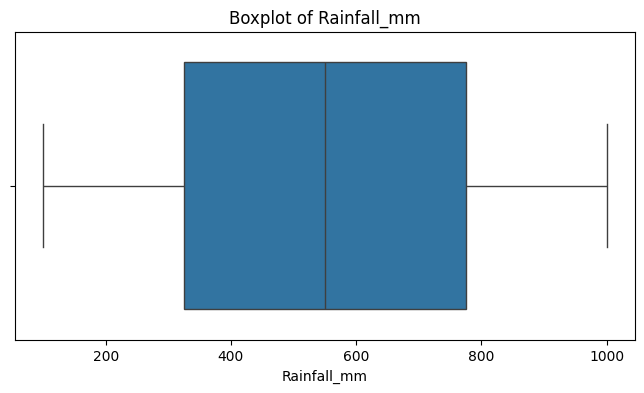

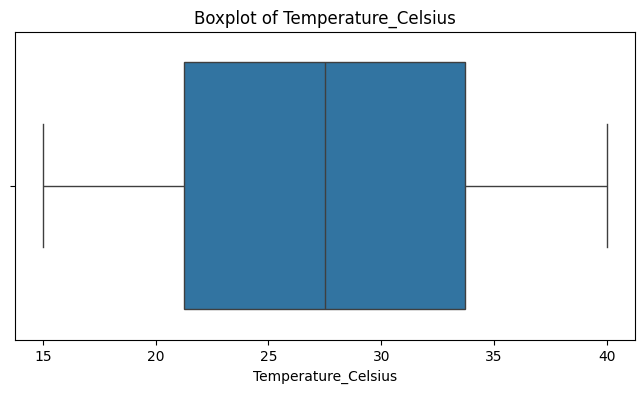

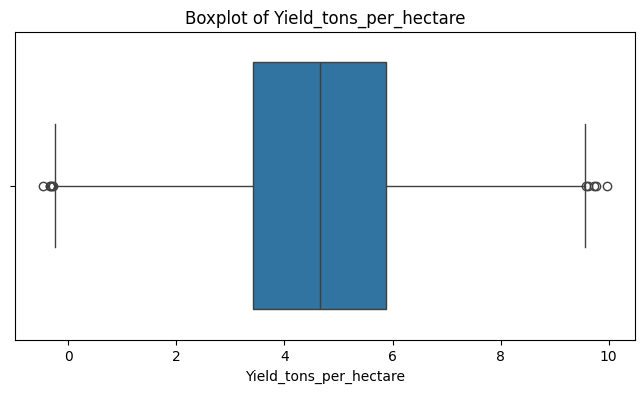

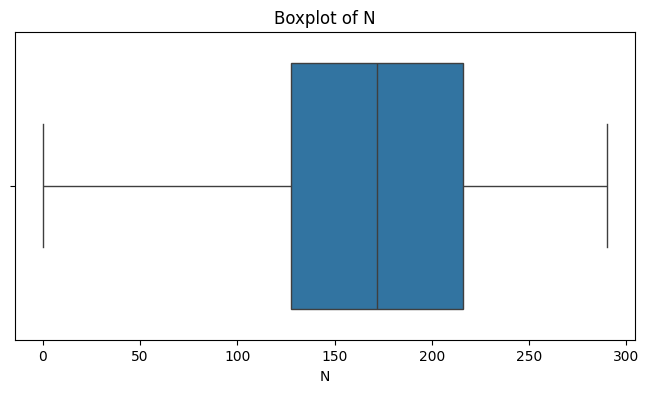

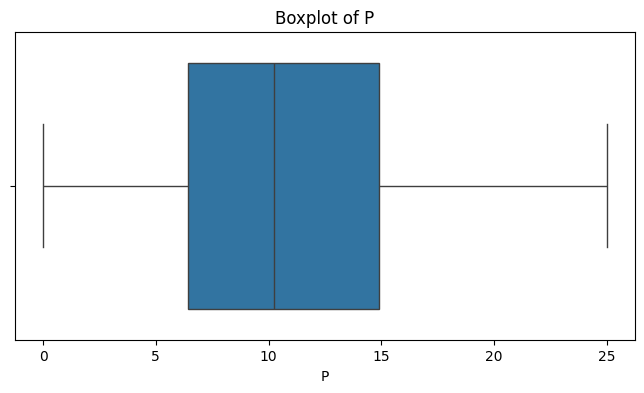

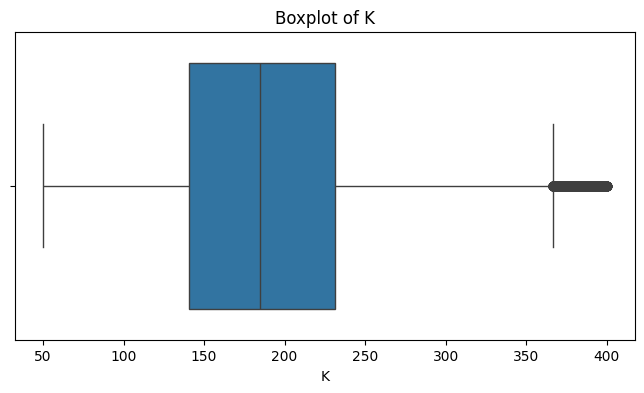

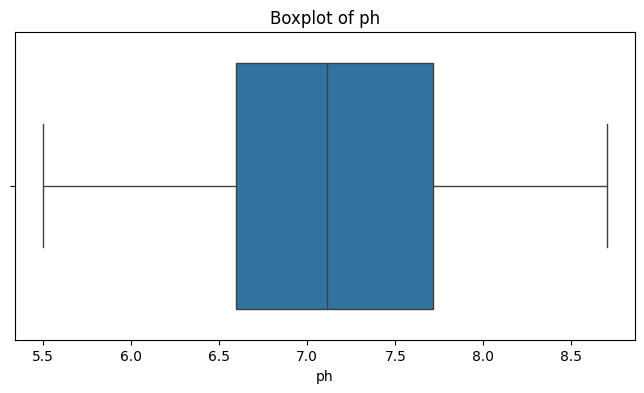

Number of outliers in 'K': 3692
Number of outliers in 'Yield_tons_per_hectare': 10


In [7]:
numeric_cols = ['Rainfall_mm', 'Temperature_Celsius', 'Yield_tons_per_hectare', 'N', 'P', 'K', 'ph']

# Plot boxplots for numerical variables
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

def count_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers.count()

print("Number of outliers in 'K':", count_outliers_iqr(df['K']))
print("Number of outliers in 'Yield_tons_per_hectare':", count_outliers_iqr(df['Yield_tons_per_hectare']))


In [8]:
# stratified sampling

df['K_bin'] = pd.qcut(df['K'], q=4, labels=False)
df['yield_bin'] = pd.qcut(df['Yield_tons_per_hectare'], q=4, labels=False)
df['strat_bin'] = df['K_bin'].astype(str) + '_' + df['yield_bin'].astype(str)

df_train_val, df_test = train_test_split(df, test_size=0.15, stratify=df['strat_bin'], random_state=42)
df_train, df_val = train_test_split(df_train_val, test_size=0.1765, stratify=df_train_val['strat_bin'], random_state=42)

# Drop auxiliary columns
df_train = df_train.drop(columns=['K_bin', 'yield_bin', 'strat_bin'])
df_val = df_val.drop(columns=['K_bin', 'yield_bin', 'strat_bin'])
df_test = df_test.drop(columns=['K_bin', 'yield_bin', 'strat_bin'])

X_train = df_train.drop('Yield_tons_per_hectare', axis=1)
y_train = df_train['Yield_tons_per_hectare']
X_val = df_val.drop('Yield_tons_per_hectare', axis=1)
y_val = df_val['Yield_tons_per_hectare']
X_test = df_test.drop('Yield_tons_per_hectare', axis=1)
y_test = df_test['Yield_tons_per_hectare']


In [13]:
X_test.head(1)

,Region,Soil_Type,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,N,P,K,ph
43847,1,3,182.055453,23.322808,0,1,126.951925,8.072558,144.775985,5.954298


In [14]:
y_test.head(1)

43847    2.498912
Name: Yield_tons_per_hectare, dtype: float64

In [ ]:
rf_model2 = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model2.fit(X_train, y_train)


def print_metrics(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    std_err = np.std(y_true - y_pred)
    print(f"{dataset_name} - R2: {r2:.4f}, RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, Std Err: {std_err:.4f}")

y_train_pred = rf_model2.predict(X_train)
y_val_pred = rf_model2.predict(X_val)
y_test_pred = rf_model2.predict(X_test)

print_metrics(y_train, y_train_pred, "Train")
print_metrics(y_val, y_val_pred, "Validation")
print_metrics(y_test, y_test_pred, "Test")

# Train - R2: 0.9870, RMSE: 0.1938, MSE: 0.0376, MAE: 0.1533, Std Err: 0.1938
# Validation - R2: 0.9058, RMSE: 0.5212, MSE: 0.2717, MAE: 0.4162, Std Err: 0.5212
# Test - R2: 0.9070, RMSE: 0.5185, MSE: 0.2688, MAE: 0.4150, Std Err: 0.5185

Train - R2: 0.9870, RMSE: 0.1938, MSE: 0.0376, MAE: 0.1533, Std Err: 0.1938
Validation - R2: 0.9058, RMSE: 0.5212, MSE: 0.2717, MAE: 0.4162, Std Err: 0.5212
Test - R2: 0.9070, RMSE: 0.5185, MSE: 0.2688, MAE: 0.4150, Std Err: 0.5185


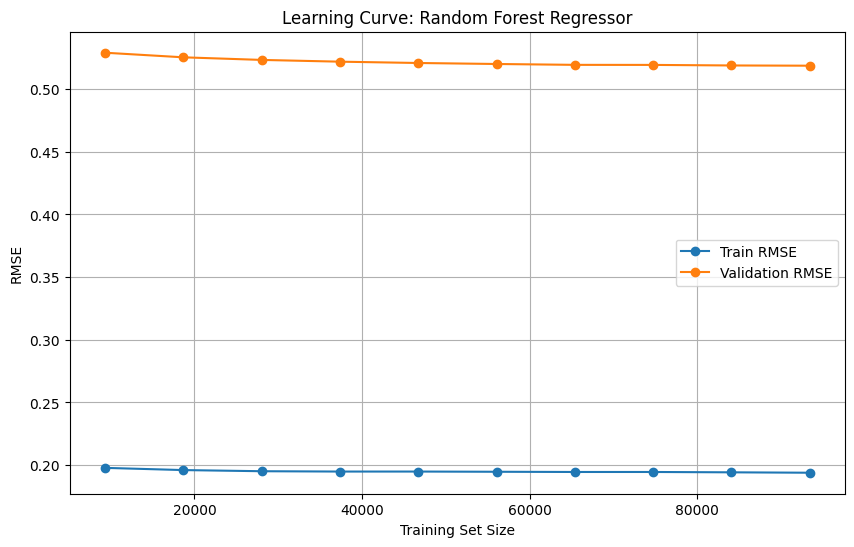

In [16]:
# rf_model2 learning curve
def rmse_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return -np.sqrt(mean_squared_error(y, y_pred))

train_sizes, train_scores, val_scores = learning_curve(
    rf_model2,
    X_train,
    y_train,
    scoring=rmse_scorer,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_rmse = -np.mean(train_scores, axis=1)
val_rmse = -np.mean(val_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_rmse, label="Train RMSE", marker='o')
plt.plot(train_sizes, val_rmse, label="Validation RMSE", marker='o')
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.title("Learning Curve: Random Forest Regressor")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# hyper param for rf
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error',
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

# already found, dont run



In [ ]:
best_params = {
    'n_estimators': 300,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'max_depth': 30,
    'random_state': 42
}

# Create and train the model
best_rf_model = RandomForestRegressor(**best_params)
best_rf_model.fit(X_train, y_train)

y_train_pred = best_rf_model.predict(X_train)
y_val_pred = best_rf_model.predict(X_val)
y_test_pred = best_rf_model.predict(X_test)

print_metrics(y_train, y_train_pred, "Train")
print_metrics(y_val, y_val_pred, "Validation")
print_metrics(y_test, y_test_pred, "Test")

# Train - R2: 0.9550, RMSE: 0.3601, MSE: 0.1297, MAE: 0.2822, Std Err: 0.3601
# Validation - R2: 0.9098, RMSE: 0.5100, MSE: 0.2601, MAE: 0.4073, Std Err: 0.5100
# Test - R2: 0.9102, RMSE: 0.5095, MSE: 0.2595, MAE: 0.4078, Std Err: 0.5094


Train - R2: 0.9550, RMSE: 0.3601, MSE: 0.1297, MAE: 0.2822, Std Err: 0.3601
Validation - R2: 0.9098, RMSE: 0.5100, MSE: 0.2601, MAE: 0.4073, Std Err: 0.5100
Test - R2: 0.9102, RMSE: 0.5095, MSE: 0.2595, MAE: 0.4078, Std Err: 0.5094


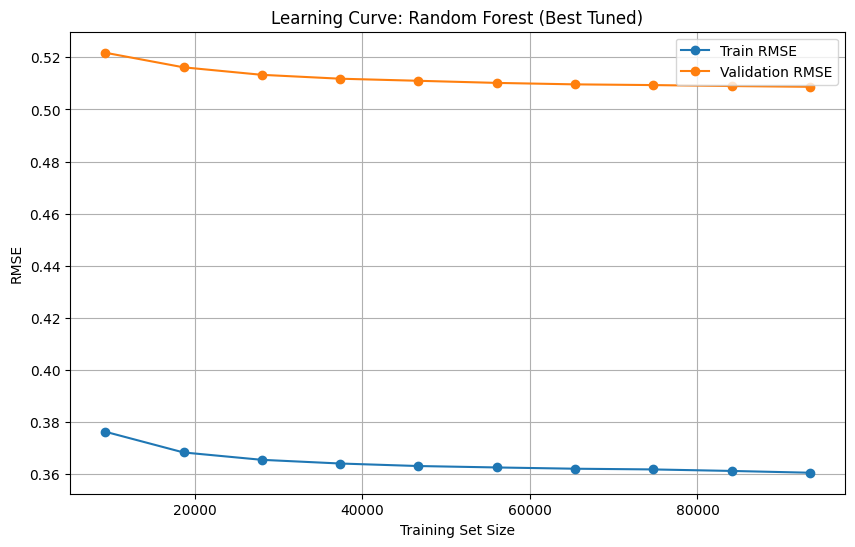

In [18]:
train_sizes, train_scores, val_scores = learning_curve(
    best_rf_model,
    X_train,
    y_train,
    scoring=rmse_scorer,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_rmse = -np.mean(train_scores, axis=1)
val_rmse = -np.mean(val_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_rmse, label="Train RMSE", marker='o')
plt.plot(train_sizes, val_rmse, label="Validation RMSE", marker='o')
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.title("Learning Curve: Random Forest (Best Tuned)")
plt.legend()
plt.grid(True)
plt.show()


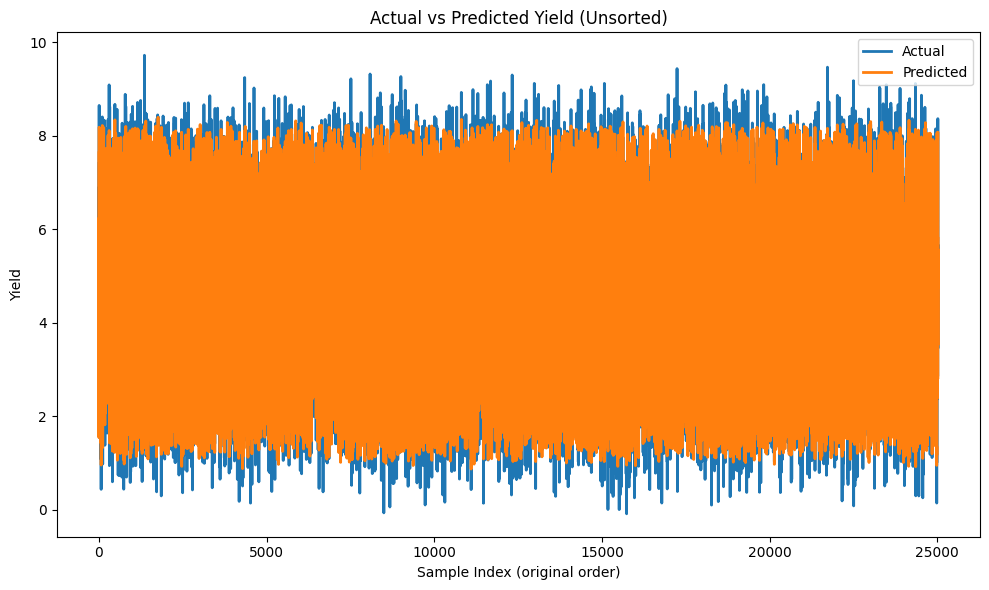

In [19]:


# Predict on validation (or choose train/test accordingly)
y_val_pred = best_rf_model.predict(X_val)

plt.figure(figsize=(10, 6))
plt.plot(y_val.values, label='Actual', linewidth=2)
plt.plot(y_val_pred, label='Predicted', linewidth=2)
plt.xlabel('Sample Index (original order)')
plt.ylabel('Yield')
plt.title('Actual vs Predicted Yield (Unsorted)')
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
# # AdaBoost Regressor with hyperparameter tuning, training and metrics

# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.model_selection import GridSearchCV


# ada_model = AdaBoostRegressor(random_state=42)

# param_grid_ada = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.5, 1.0],
#     'loss': ['linear', 'square', 'exponential']
# }

# grid_ada = GridSearchCV(ada_model, param_grid_ada, cv=3, scoring='neg_mean_squared_error', n_jobs=1, verbose=2)
# grid_ada.fit(X_train, y_train)

# best_ada = grid_ada.best_estimator_
# print("Best AdaBoost params:", grid_ada.best_params_)

from sklearn.ensemble import AdaBoostRegressor

# Best parameters found
best_params_ada = {
    'learning_rate': 1.0,
    'loss': 'square',
    'n_estimators': 200,
    'random_state': 42
}

# Initialize and train the AdaBoost model with best parameters
best_ada = AdaBoostRegressor(**best_params_ada)
best_ada.fit(X_train, y_train)

# Define function to print metrics
def print_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    sd = np.std(y_true - y_pred)
    print(f"{dataset_name} - R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}, SD: {sd:.4f}")

# Predict and print metrics for train, validation, and test sets
print_metrics(y_train, best_ada.predict(X_train), "Train")
print_metrics(y_val, best_ada.predict(X_val), "Validation")
print_metrics(y_test, best_ada.predict(X_test), "Test")


# # Best AdaBoost params: {'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 200}
# # Train - R2: 0.8943, RMSE: 0.5520, MAE: 0.4411, MSE: 0.3047, SD: 0.5520
# # Validation - R2: 0.8942, RMSE: 0.5513, MAE: 0.4397, MSE: 0.3039, SD: 0.5512
# # Test - R2: 0.8959, RMSE: 0.5499, MAE: 0.4395, MSE: 0.3024, SD: 0.5499

Train - R2: 0.8914, RMSE: 0.5595, MAE: 0.4471, MSE: 0.3131, SD: 0.5594
Validation - R2: 0.8918, RMSE: 0.5588, MAE: 0.4471, MSE: 0.3123, SD: 0.5588
Test - R2: 0.8903, RMSE: 0.5633, MAE: 0.4502, MSE: 0.3173, SD: 0.5632


In [35]:
from sklearn.ensemble import GradientBoostingRegressor

# Set fixed parameters as you prefer
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    random_state=42
)

# Fit model
gb_model.fit(X_train, y_train)

def print_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    sd = np.std(y_true - y_pred)
    print(f"{dataset_name} - R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}, SD: {sd:.4f}")

# Print metrics for all sets
print_metrics(y_train, gb_model.predict(X_train), "Train")
print_metrics(y_val, gb_model.predict(X_val), "Validation")
print_metrics(y_test, gb_model.predict(X_test), "Test")


# Train - R2: 0.9128, RMSE: 0.5012, MAE: 0.3999, MSE: 0.2513, SD: 0.5012
# Validation - R2: 0.9120, RMSE: 0.5026, MAE: 0.4006, MSE: 0.2526, SD: 0.5026
# Test - R2: 0.9127, RMSE: 0.5035, MAE: 0.4031, MSE: 0.2535, SD: 0.5035

Train - R2: 0.9130, RMSE: 0.5006, MAE: 0.3993, MSE: 0.2506, SD: 0.5006
Validation - R2: 0.9118, RMSE: 0.5045, MAE: 0.4028, MSE: 0.2545, SD: 0.5044
Test - R2: 0.9121, RMSE: 0.5042, MAE: 0.4031, MSE: 0.2542, SD: 0.5041


In [44]:
with open('gb_model_rice.pkl', 'wb') as f:
    pickle.dump(gb_model, f)

print("Models and encoders saved successfully.")

Models and encoders saved successfully.


In [39]:
# Example input single row with feature columns in correct order
input_data = {
    'Region': [3],
    'Soil_Type': [0],
    'Rainfall_mm': [590.309080],
    'Temperature_Celsius': [30.241923],
    'Fertilizer_Used': [1],
    'Irrigation_Used': [1],
    'N': [145.558201],
    'P': [6.911538],
    'K': [158.498665],
    'ph': [8.287763]
}

input_df = pd.DataFrame(input_data)

prediction = gb_model.predict(input_df)
print("Predicted Yield:", prediction[0])


Predicted Yield: 6.228413735791304


In [1]:
X_val.head(3)

NameError: name 'X_val' is not defined

In [ ]:
y_val.head(3)

43847     2.498912
382422    2.524497
418020    6.295306
Name: Yield_tons_per_hectare, dtype: float64

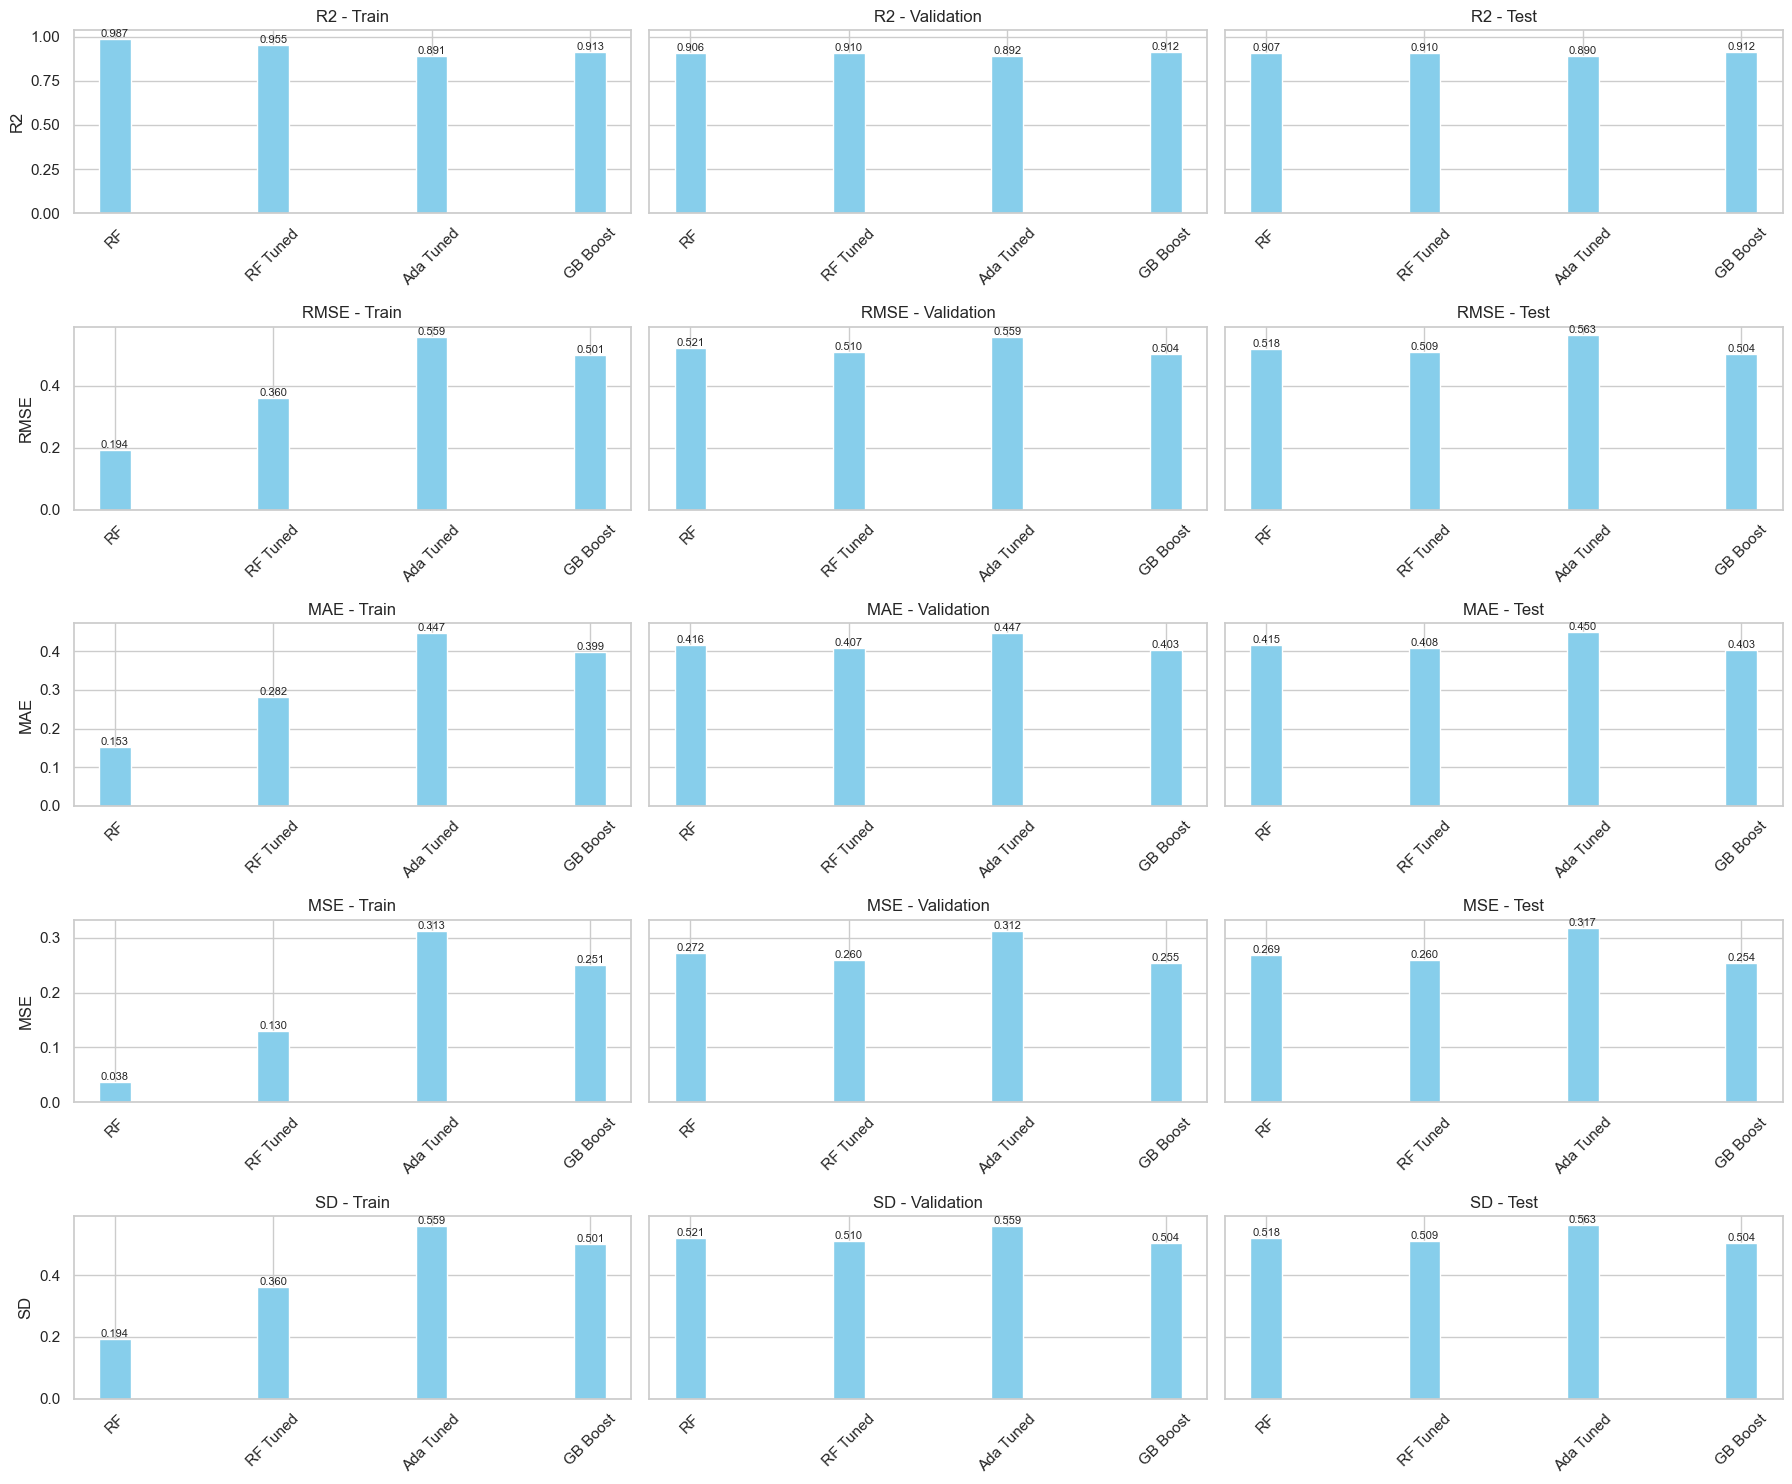

In [41]:


# Updated data including provided values
data = {
    'Model': ['RF', 'RF Tuned', 'Ada Tuned', 'GB Boost'],
    'Train R2': [0.9870, 0.9550, 0.8914, 0.9130],
    'Validation R2': [0.9058, 0.9098, 0.8918, 0.9118],
    'Test R2': [0.9070, 0.9102, 0.8903, 0.9121],
    'Train RMSE': [0.1938, 0.3601, 0.5595, 0.5006],
    'Validation RMSE': [0.5212, 0.5100, 0.5588, 0.5045],
    'Test RMSE': [0.5185, 0.5095, 0.5633, 0.5042],
    'Train MAE': [0.1533, 0.2822, 0.4471, 0.3993],
    'Validation MAE': [0.4162, 0.4073, 0.4471, 0.4028],
    'Test MAE': [0.4150, 0.4078, 0.4502, 0.4031],
    'Train MSE': [0.0376, 0.1297, 0.3131, 0.2506],
    'Validation MSE': [0.2717, 0.2601, 0.3123, 0.2545],
    'Test MSE': [0.2688, 0.2595, 0.3173, 0.2542],
    'Train SD': [0.1938, 0.3601, 0.5594, 0.5006],
    'Validation SD': [0.5212, 0.5100, 0.5588, 0.5044],
    'Test SD': [0.5185, 0.5094, 0.5632, 0.5041]
}

df = pd.DataFrame(data)
df.set_index('Model', inplace=True)

metrics = ['R2', 'RMSE', 'MAE', 'MSE', 'SD']
stages = ['Train', 'Validation', 'Test']

fig, axes = plt.subplots(len(metrics), len(stages), figsize=(18, 15), sharey='row')
bar_width = 0.2
x = np.arange(len(df.index))  # Model indices

for i, metric in enumerate(metrics):
    for j, stage in enumerate(stages):
        ax = axes[i, j]
        vals = df[f'{stage} {metric}']
        ax.bar(x, vals, width=bar_width, color='skyblue')
        ax.set_xticks(x)
        ax.set_xticklabels(df.index, rotation=45)
        ax.set_title(f'{metric} - {stage}')
        for idx, val in enumerate(vals):
            ax.text(idx, val, f'{val:.3f}', ha='center', va='bottom', fontsize=8)
        if j == 0:
            ax.set_ylabel(metric)

plt.tight_layout()
plt.show()
